In [53]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv('../env_file')

# Access the environment variables
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")

# Create the engine using the environment variables
engine = create_engine(f'mysql+pymysql://{db_user}:{db_password}@{db_host}:{db_port}/employee_attrition')

In [2]:
query = 'SELECT * FROM employee_data'
df = pd.read_sql(query, engine)

In [3]:
df.head()

,age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# What are the major factors that impact attrition? 

## Why does attrition matter?

From a financial perspective, **attrition is costly**. Apart from cost, it may **indicate potential issues with company culture, work environment, job satisfaction, and much more**. Based on this dataset, **there is a 22% attrition rate for employees who have a job satisfaction score of 1, versus 11% for those with a job satisfaction score of 4**. Deeper understanding of attrition can shed insights on how each team can improve different touch points in the employee life cycle. 

*Note: This is a fictional data set and have many limitations, which require deep dive in variety of other factors. A few limitations include exit survey, termination details (regrettable/non-regrettable voluntary and involuntary), further insights on comparing employees with their cohorts who onboarded at the same time), engagement survey, onboarding survey, and many more.*

In [4]:
# distribution of job satisfaction and attrition rates by job satisfaction
query = '''SELECT JobSatisfaction,
                SUM(CASE WHEN attrition = 'YES' THEN 1 ELSE 0 END) / COUNT(*) * 100 AS AttritionRate, COUNT(*) AS EmployeeCount
           FROM employee_data
           GROUP BY JobSatisfaction
           ORDER BY JobSatisfaction;
           '''

df_1 = pd.read_sql(query, engine)

In [5]:
df_1

,JobSatisfaction,AttritionRate,EmployeeCount
0,1,22.8374,289
1,2,16.4286,280
2,3,16.5158,442
3,4,11.3290,459


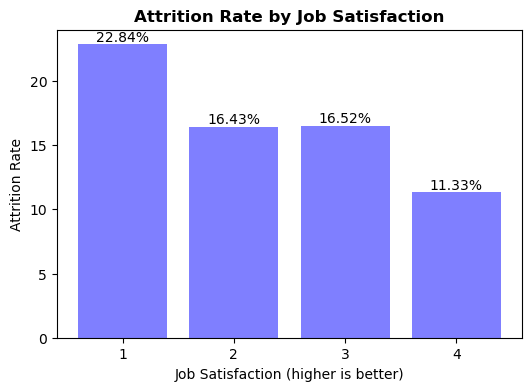

In [52]:
plt.figure(figsize=(6, 4))
bars = plt.bar(df_1['JobSatisfaction'], df_1['AttritionRate'], alpha=0.5, color='blue', label='Attrition Rate')
plt.xlabel('Job Satisfaction (higher is better)')
plt.ylabel('Attrition Rate')
plt.title('Attrition Rate by Job Satisfaction', fontweight='bold')

# add labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:.2f}%', ha='center', va='bottom', color='black', fontsize=10)

# set x-axis ticks to display only integer values
plt.xticks(df_1['JobSatisfaction'])

plt.show()

Employees with a job satisfaction score of 1 has a 22% attrition rate, which is above the generally accepted rate (20%). Employees with a job satsifaction score of 2 and 3 have similar attrition rates at 16% and employees with highest job satisfaction have a 11% attrition rate. It might be worthy to first focus more on employees with a job satisfaction score of 1.

In [7]:
# average job satisfaction by attrition
query = '''SELECT Attrition, AVG(JobSatisfaction) as Avg_Satisfaction, Count(*) AS EmployeeCount
           FROM employee_data
           GROUP BY Attrition;
           '''

df_2 = pd.read_sql(query, engine)

In [8]:
df_2

,Attrition,Avg_Satisfaction,EmployeeCount
0,Yes,2.4684,237
1,No,2.7786,1233


#TODO: hypothesis testing

## Possible factors impacting attrition: 

### 1. Flexibility in work arrangements

Regarding business travels, the **attrition rate is higher for all frequent travelers** in each bucket of job satisfaction. Regarding commute, there is also an obvious **higher attrition rate among those who live 8+ miles away.** 

In [9]:
# looking at whether employees from specific department travels more to avoid unfair comparison without accounting for difference in nature of roles 
query = '''WITH travel_percentage AS (
           SELECT CASE WHEN BusinessTravel = 'Travel_Rarely' THEN 'rare_travelers'
                       WHEN BusinessTravel = 'Non_Travel' THEN 'rare_travelers'
                       ELSE 'frequent_travelers'
                  END AS travel_frequency, EmployeeNumber
           FROM employee_data
           ) -- this is a CTE to group employees into two buckets: rare travelers and frequent travelers. Rare travelers include employees who does not travel and rarely travels.
           
           SELECT e.Department,
                  SUM(CASE WHEN travel_frequency = 'frequent_travelers' THEN 1 ELSE 0 END) / COUNT(*) * 100 AS Travel_Rate, 
                  COUNT(*) AS EmployeeCount
           FROM travel_percentage t
           JOIN employee_data e
           ON e.EmployeeNumber = t.EmployeeNumber
           GROUP BY e.Department;
           '''

df_3 = pd.read_sql(query, engine)

In [10]:
df_3

,Department,Travel_Rate,EmployeeCount
0,Sales,29.3722,446
1,Research & Development,29.0323,961
2,Human Resources,26.9841,63


There is no significant difference in travel frequency among employees from different departments.

In [11]:
# attrition rate by travel frequency and job satisfaction

query = '''SELECT JobSatisfaction, CASE WHEN BusinessTravel = 'Travel_Rarely' THEN 'rare_travelers'
                    WHEN BusinessTravel = 'Non_Travel' THEN 'rare_travelers'
                    ELSE 'frequent_travelers'
               END AS travel_frequency,
                 SUM(CASE WHEN attrition = 'YES' THEN 1 ELSE 0 END) / COUNT(*) * 100 AS AttritionRate, Count(*) AS EmployeeCount
           FROM employee_attrition.employee_data
           GROUP BY JobSatisfaction, travel_frequency
           ORDER BY JobSatisfaction, travel_frequency;
           '''

df_4 = pd.read_sql(query, engine)

In [12]:
df_4

,JobSatisfaction,travel_frequency,AttritionRate,EmployeeCount
0,1,frequent_travelers,29.7297,74
1,1,rare_travelers,20.4651,215
2,2,frequent_travelers,19.2308,78
3,2,rare_travelers,15.3465,202
4,3,frequent_travelers,19.5652,138
5,3,rare_travelers,15.1316,304
6,4,frequent_travelers,12.4088,137
7,4,rare_travelers,10.8696,322


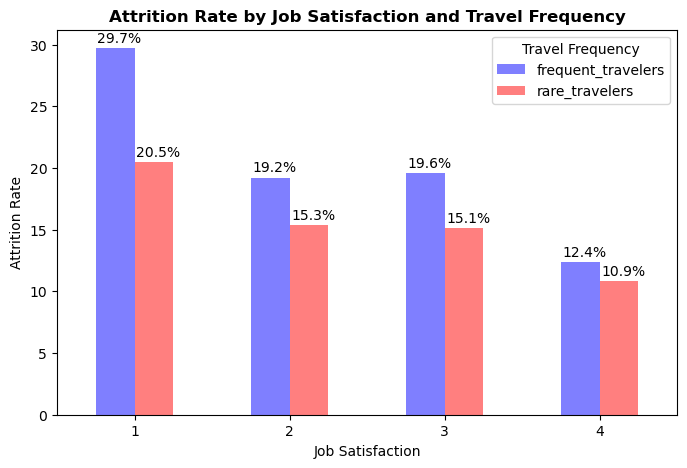

In [27]:
# create a pivot table for better plotting
pivot_df = df_4.pivot(index='JobSatisfaction', columns='travel_frequency', values='AttritionRate')

# plotting the grouped bar chart
ax = pivot_df.plot(kind='bar', figsize=(8, 5), alpha=0.5, color=['blue', 'red'])

plt.xlabel('Job Satisfaction')
plt.ylabel('Attrition Rate')
plt.title('Attrition Rate by Job Satisfaction and Travel Frequency', fontweight='bold')
plt.xticks(rotation='horizontal')
# add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(3, 7), textcoords='offset points', color='black', fontsize=10)

plt.legend(title='Travel Frequency')
plt.show()

Attrition rate is higher among frequent travelers across all job satisfaction levels.

In [32]:
# distribution of employees based on how far they live from work

query = '''SELECT (DistanceFromHome - MOD(DistanceFromHome, 4)) AS Distance_Group, COUNT(*) AS EmployeeCount
           FROM employee_data
           WHERE Attrition = 'Yes'
           GROUP BY Distance_Group
           ORDER BY Distance_Group;'''

df_5 = pd.read_sql(query, engine)

In [33]:
df_5

,Distance_Group,EmployeeCount
0,0,68
1,4,37
2,8,43
3,12,21
4,16,19
5,20,18
6,24,24
7,28,7


Most employees live within 8 miles from work.

In [34]:
# attrition rate by distance from home and job satisfaction

query = '''SELECT JobSatisfaction, CASE WHEN DistanceFromHome >= 8 THEN 'above'
                     ELSE 'below' 
                END AS Below_Above_8miles,
                SUM(CASE WHEN attrition = 'YES' THEN 1 ELSE 0 END) / COUNT(*) * 100 AS AttritionRate, Count(*) AS EmployeeCount
        FROM employee_attrition.employee_data
        GROUP BY JobSatisfaction, Below_Above_8miles
        ORDER BY JobSatisfaction, Below_Above_8miles;
        '''

df_6 = pd.read_sql(query, engine)

In [35]:
df_6

,JobSatisfaction,Below_Above_8miles,AttritionRate,EmployeeCount
0,1,above,28.5714,140
1,1,below,17.4497,149
2,2,above,20.0000,135
3,2,below,13.1034,145
4,3,above,17.9245,212
5,3,below,15.2174,230
6,4,above,12.9808,208
7,4,below,9.9602,251


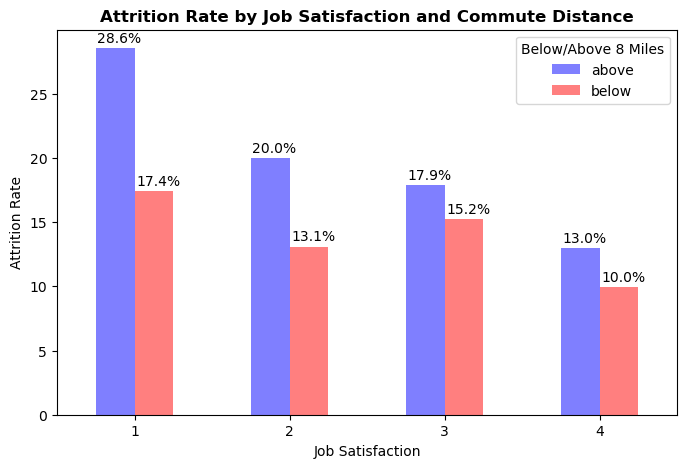

In [38]:
# Combine JobSatisfaction and Below_Above_8miles for unique bars
df_6['combined'] = df_6['JobSatisfaction'].astype(str) + '_' + df_6['Below_Above_8miles']

# Create a pivot table for better plotting
pivot_df_6 = df_6.pivot(index='JobSatisfaction', columns='Below_Above_8miles', values='AttritionRate')

# Plotting the grouped bar chart
ax = pivot_df_6.plot(kind='bar', figsize=(8, 5), alpha=0.5, color=['blue', 'red'])

plt.xlabel('Job Satisfaction')
plt.ylabel('Attrition Rate')
plt.title('Attrition Rate by Job Satisfaction and Commute Distance', fontweight='bold')
plt.xticks(rotation='horizontal')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(3, 7), textcoords='offset points', color='black', fontsize=10)
    
# Add legend
plt.legend(title='Below/Above 8 Miles')

plt.show()

Generally, attrition rate is higher for employees who live 8+ miles away. 

### Career Growth

While the majority of employees received a promotion within the last 2 years, **attrition rate is higher for employees who were promoted within the last 2 years than those who were NOT promoted within the last 2 years**. This shows that **promotion doesn't seem to play a big impact in attrition.** 

In [39]:
# employees count by years since last promotion for employees who left and have a job satisfaction score of 1

query = '''SELECT YearsSinceLastPromotion, Count(*) AS EmployeeCount
           FROM employee_data
           WHERE Attrition = 'Yes'
           GROUP BY YearsSinceLastPromotion
           ORDER BY YearsSinceLastPromotion;'''

df_7 = pd.read_sql(query, engine)

In [40]:
df_7

,YearsSinceLastPromotion,EmployeeCount
0,0,110
1,1,49
2,2,27
3,3,9
4,4,5
5,5,2
6,6,6
7,7,16
8,9,4
9,10,1


Majority of employees who left was promoted within the last 2 years.

In [41]:
# attrition rate by whether they were promoted within the last 2 years or not and job satisfaction

query = '''SELECT JobSatisfaction, 
                  CASE WHEN YearsSinceLastPromotion <= 2 THEN 'Yes'
                       ELSE 'No'
                  END AS Promoted_Within_Last2years,
                  SUM(CASE WHEN attrition = 'YES' THEN 1 ELSE 0 END) / COUNT(*) * 100 AS AttritionRate, Count(*) AS EmployeeCount
           FROM employee_data
           GROUP BY JobSatisfaction, promoted_within_last2years
           ORDER BY JobSatisfaction, promoted_within_last2years;
           '''

df_8 = pd.read_sql(query, engine)

In [45]:
df_8

,JobSatisfaction,Promoted_Within_Last2years,AttritionRate,EmployeeCount,combined
0,1,No,14.6667,75,1_No
1,1,Yes,25.7009,214,1_Yes
2,2,No,14.8649,74,2_No
3,2,Yes,16.9903,206,2_Yes
4,3,No,13.0841,107,3_No
5,3,Yes,17.6119,335,3_Yes
6,4,No,12.8205,117,4_No
7,4,Yes,10.8187,342,4_Yes


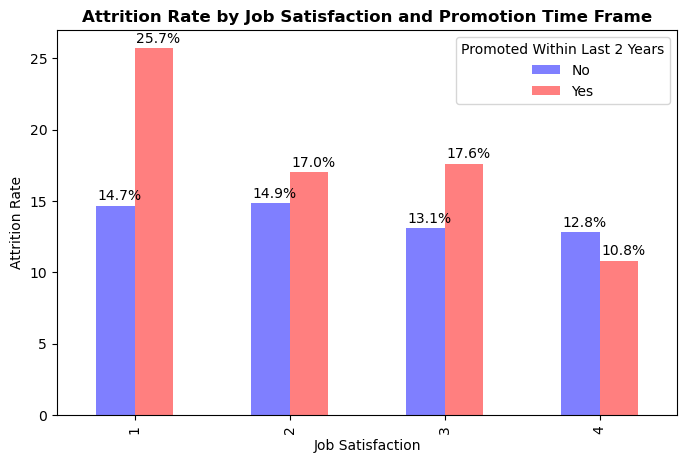

In [46]:
# combine JobSatisfaction and Promoted_Within_Last2years for unique bars
df_8['combined'] = df_8['JobSatisfaction'].astype(str) + '_' + df_8['Promoted_Within_Last2years']

# create a pivot table for better plotting
pivot_df_8 = df_8.pivot(index='JobSatisfaction', columns='Promoted_Within_Last2years', values='AttritionRate')

# plotting the grouped bar chart
ax = pivot_df_8.plot(kind='bar', figsize=(8, 5), alpha=0.5, color=['blue', 'red'])

plt.xlabel('Job Satisfaction')
plt.ylabel('Attrition Rate')
plt.title('Attrition Rate by Job Satisfaction and Promotion Time Frame', fontweight='bold')

# add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(3, 7), textcoords='offset points', color='black', fontsize=10)

plt.legend(title='Promoted Within Last 2 Years')
plt.show()

Employees who were promoted within the last 2 years have higher attrition across each job satisfaction, except for those with a job satisfaction score of 4. Especially employees with job satisfaction score of 1 have an alarmingly high attrition rate of 25% despite being promoted within the last 2 years.

### Compensation

**Attrition rate is higher for employees whose monthly income is lower than the average monthly income.** Employees' monthly income are compared to the average monthly income of those who are within the same job level to ensure fairness. 

In [47]:
# attrition rate by compensation level below or above average and by job level

query = '''SELECT CompensationLevel, SUM(CASE WHEN attrition = 'YES' THEN 1 ELSE 0 END) / COUNT(*) * 100 AS AttritionRate,
           Count(*) AS TotalEmployees
           FROM (SELECT CASE WHEN MonthlyIncome > (
                                SELECT AVG(e2.MonthlyIncome)
                                FROM employee_data e2
                                WHERE e2.JobLevel = e1.JobLevel) -- employees' monthly income are compared based on job levels to ensure fairness
                            THEN 'Above Average'
                            ELSE 'Below Average'
                        END AS CompensationLevel,
                        Attrition
                 FROM employee_data e1
            ) t
            GROUP BY CompensationLevel;
        '''

df_9 = pd.read_sql(query, engine)

In [48]:
df_9

,CompensationLevel,AttritionRate,TotalEmployees
0,Above Average,13.2331,665
1,Below Average,18.5093,805


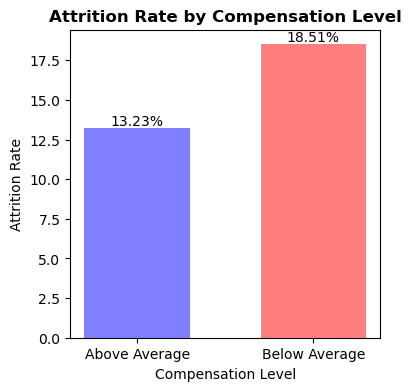

In [51]:
# plotting the bar chart with specified color and alpha
fig, ax1 = plt.subplots(figsize=(4, 4))

# bar plot for AttritionRate with adjusted width and alpha
ax1.set_xlabel('Compensation Level')
ax1.set_ylabel('Attrition Rate', color='black')
bars = ax1.bar(df_9['CompensationLevel'], df_9['AttritionRate'], width=0.6, alpha=0.5, color=['blue', 'red'])
ax1.tick_params(axis='y', labelcolor='black')

# adding labels to bars
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', color='black', fontsize=10)

# adding title
plt.title('Attrition Rate by Compensation Level', fontweight='bold')

plt.show()

Attrition rate is higher at 18% versus 13% for employees who have average monthly income below average. 

# Conclusion

Out of factors explored above: 1. flexibility in work arrangements (commute and travel requirements) 2. career growth (promotions) 3. compensation (monthly income), **there is an apparent higher attrition rate regarding flexibility in work arrangements and compensation.** 

Employees who live further away and travel frequently have much higher attrition rates (>20%), especially those with a job satisfaction score of 1. Employees with above average monthly income also has lower attrition rates compared to those with below average monthly income (13% vs 18%). 

# Next Steps

There are couple of next steps we can take in order to improve the attrition analysis and retain talents:

**1. Gather more data to approach attrition with a more holisitc perspective**: Gather data on exit surveys, onboarding survey, termination details, and more for further analysis. These data will not only provide a more holistic perspective on attrition, but also provide qualitative data, allowing the team to see what employees' feedback. It may also be worth it to loop in HR Business Partners for additional insights as they typically support sensitive termination cases. 

**2. Explore the future of work**: Remote work has been much more popular since COVID. Being in the office and in person is indispensable to foster collaboration, however, it is necessary to deep dive into how to approach the future of work to maintain the collaborative nature and connectiveness of employees while providing certain flexibilities as long as performance and efficiency can be maintained.

**3. Review total rewards structure in a regular cadence**: It is important to look at all different areas including compensation, benefits, stocks, and recognition programs to retain talent. The entire package needs to constantly meet evolving changes in the competitive market. For instance, many employers are starting to provide longer maternity leaves or fertility services in order to really support employees in important moments of their lives.
